### Training deep neural networks

@cesans

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import sys
sys.path.append('../')
import numpy as np

import deep_control as dc

import seaborn as sns

### Loading data

Previously generated trajectories can be loaded with *dc.data.load_trajectories*

In [25]:
import glob
import pickle
from tqdm import tqdm

files = glob.glob('../data/simple/*pic')

In [68]:
total = 0
trajs = []
for f in tqdm(files, leave=True):    
        rw = pickle.load(open(f,'rb'))
        for rwi in rw:
            traj = np.hstack((rwi[0], rwi[1]))
            df = pandas.DataFrame(data=traj)
            col_names = ['t', 'x', 'y', 'z', 'vz', 'm', 'u1', 'u2']
            df.columns = col_names
            trajs.append(df)


100%|██████████| 186/186 [00:09<00:00, 19.89it/s]


## Training

From the trajectories we can generate the training sets:

In [115]:
train_p = 0.9 # proportion of training data
x_train, y_train, x_test, y_test, idx_train = dc.data.create_training_data(trajs, train_p = train_p, n_outputs=2)

Creating test data: 100%|██████████| 2879/2879 [00:00<00:00, 2986.60it/s]


In [116]:
dc.nn.save_training_data([x_train, y_train, x_test, y_test, idx_train], "indirect_simple")

We specify a model to train

In [29]:
model_description = {"data": "indirect_simple",
                     "control": dc.nn.DTHETA,
                     "nlayers": 3,
                     "units": 32, 
                     "output_mode": dc.nn.OUTPUT_LOG, 
                     "dropout": False,
                     "batch_size": 8, 
                     "epochs": 3, 
                     "lr": 0.001,
                     "input_vars" : 5,
                     "hidden_nonlinearity": "ReLu"}

In [30]:
dc.nn.train(model_description)

=====  MODEL ===========
dropout:False
units:32
epochs:3
input_vars:5
data:indirect_simple
output_mode:0
batch_size:8
hidden_nonlinearity:ReLu
nlayers:3
lr:0.001
control:1
Loading data...
Preprocessing...

Training, epoch 0: 100%|██████████| 323787/323787 [00:55<00:00, 5820.18it/s]


Training...
epoch 0, train loss: 0.0011232152513663642
epoch 0, test loss: 0.0011758376463635184


Training, epoch 1: 100%|██████████| 323787/323787 [00:57<00:00, 5592.98it/s]


epoch 1, train loss: 0.00045752103304887534
epoch 1, test loss: 0.0009713403039379541


Training, epoch 2: 100%|██████████| 323787/323787 [01:03<00:00, 5122.80it/s]


epoch 2, train loss: 0.00038744881017883454
epoch 2, test loss: 0.0008641623194415034


In [23]:
model_th = dc.nn.load_model('nets/indirect_simple/0/ReLu_outputLog_3_128.model')
network_th = dc.nn.load_network(model_th, base_dir='')



In [24]:
model_dth = dc.nn.load_model('nets/indirect_simple/1/ReLu_outputLog_3_128.model')
network_dth = dc.nn.load_network(model_dth, base_dir='')

networks = [(model_th, network_th),
            (model_dth, network_dth)]

In [25]:
data = dc.nn.load_training_data(model_th, '')

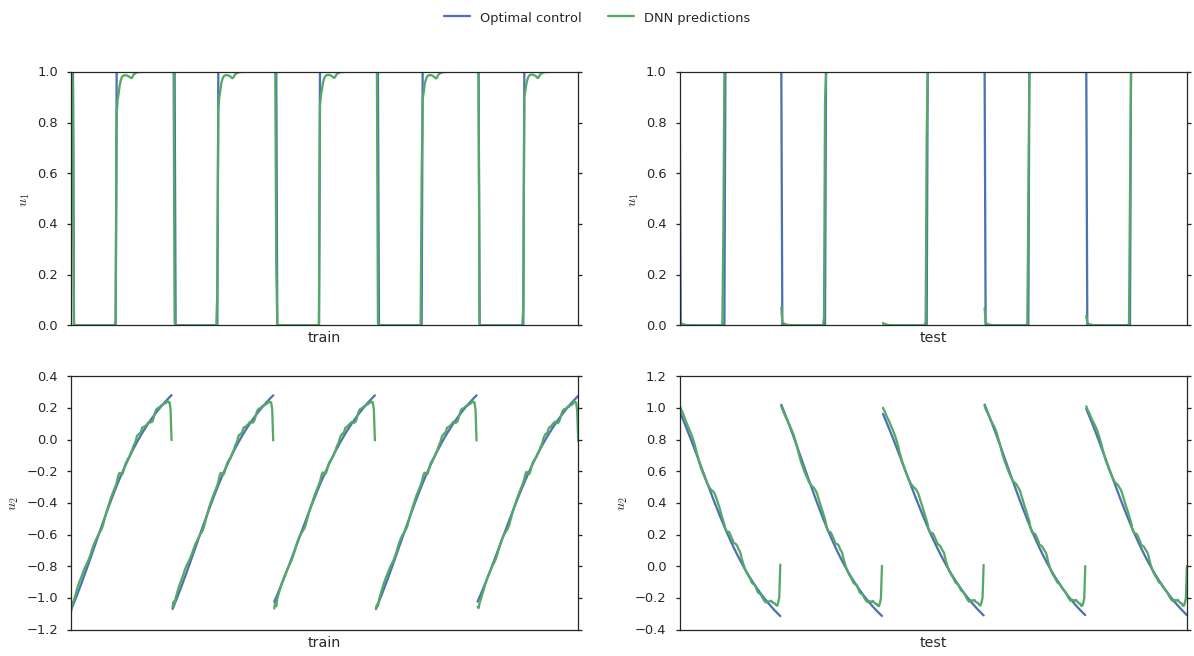

In [32]:
plt.rcParams['figure.figsize'] = [20,5*len(networks)]

fig = plt.figure()

batch = 1000
b = 200
traj_length = 100

for s, dset in enumerate(['train', 'test']):
#for s, dset in enumerate(['test']):

    for i,(model,network) in enumerate(networks):

        plt.subplot(len(networks), 2, i*2+s+1)
        u = np.zeros((batch,len(networks)))
        network_input = data['X_'+dset][b*batch:(b+1)*batch,:]
        #network_input = dc.nn.preprocess(model, network_input)
        ui = network['pred'](network_input) 
        u[:,i] = ui[:,0]

        u = dc.nn.postprocess(model, u)
        u_gt = data['Y_'+dset][b*batch:(b+1)*batch,:].copy()        
        u_gt = dc.nn.postprocess(model, u_gt)   
                
        for j in range(5):
            label_1, = plt.plot(np.arange(traj_length)+j*traj_length,u_gt[j*traj_length:(j+1)*traj_length,i], c=sns.color_palette()[0])
        #label_1, = plt.plot(u_gt[:,i], c=sns.color_palette()[1])
        
        #plt.locator_params(axis='y', nbins=1)
        
        plt.gca().get_xaxis().set_ticks([])
        plt.ylabel(r'$' + 'u_'+str(i+1)+'$')
        ylims = plt.ylim()
#        plt.vlines([traj_length*j for j in range(5)], plt.ylim()[0], plt.ylim()[1],color='gray')

        plt.subplot(len(networks), 2, i*2+s+1)        
#        label_2, = plt.plot(u[:,i])
        for j in range(5):
            label_2, = plt.plot(np.arange(traj_length)+j*traj_length, u[j*traj_length:(j+1)*traj_length,i], c=sns.color_palette()[1])
        
        #plt.locator_params(axis='y', nbins=1)
        plt.gca().get_xaxis().set_ticks([])
        plt.ylim(ylims)
        plt.xlabel(dset)
        
#        plt.vlines([traj_length*j for j in range(5)], plt.ylim()[0], plt.ylim()[1],color='gray')
                
plt.figlegend([label_1,label_2], ['Optimal control', 'DNN predictions'], loc='upper center', ncol=2)
